In [2]:
import torch
import rich
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

import utils
from importlib import reload
reload(utils)

<module 'utils' from '/datadrive1/ken/projects/rft-experiments/utils.py'>

In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

ds = datasets.load_dataset("openai/gsm8k", "main")

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [01:29<00:00, 44.56s/it]


### Getting basic sense of the data
* Number of steps to solve the problem

Text(0, 0.5, 'Count')

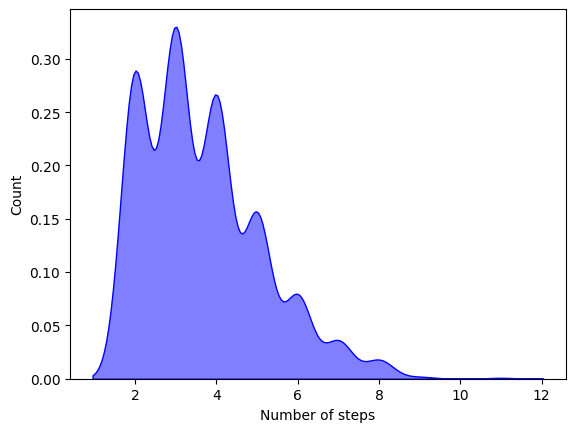

In [3]:
# Count for each answer how many lines it has
# (except the last line, which is the answer)
num_steps = []
for answer in ds["test"]["answer"]:
    lines = answer.split("\n")
    num_steps.append(len(lines) - 1)

fig, ax = plt.subplots()
sns.kdeplot(num_steps, ax=ax, fill=True, color="blue", alpha=0.5)
ax.set_xlabel("Number of steps")
ax.set_ylabel("Count")

### Getting a sense of the baseline, not a perfect replication but good to know where we are at.

In [3]:
prompt_template = """You are given a math question. You must provide a concise step-by-step reasoning
    and a final answer. Your response should follow strictly the format of the provided examples where each new line is a reasoning step
    written in a very concise style, and the final answer is on the last line. There should be roughly 2-4 steps, but it is okay
    to have more or less steps if needed.
    
    {n_shot_examples}

    # Question:
    {question}
"""

In [11]:
# Evaluate the baseline model
print(
    utils.evaluate_model(
        model=model,
        eval_dataset=ds["test"][:4],
        tokenizer=tokenizer,
        prompt_template=prompt_template,
        max_new_tokens=256,
        temperature=0.7,
        batch_size=16,
        num_examples=2,
    )
)

Evaluating model:   0%|          | 0/1 [00:00<?, ?it/s]The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.
Evaluating model: 100%|██████████| 1/1 [00:11<00:00, 11.27s/it]


0: Decoded answer:
Janet eats 3 eggs for breakfast and uses 4 for muffins, so she uses 3+4=<<3+4=7>>7 eggs daily.
She has 16 eggs in total, so she sells 16-7=<<16-7=9>>9 eggs at the farmers' market.
Since she sells each egg for $2, she makes 9*2=<<9*2=18>>18 dollars every day.
#### 18

1: Decoded answer:
Josh invested $80,000 initially and an additional $50,000 for repairs, totaling $80,000 + $50,000 = $130,000.

The 150% increase in value means the house is now worth 150% more than the initial investment, which is 1.5 * $130,000 = $195,000.

To calculate the profit, subtract the total investment from the increased value: $195,000 - $130,000 = $65,000.

#### 65,000



0.5


### Getting to know more about correct and incorrect sample characteristics
* How often do I get correct vs incorrect? Some questions are harder?
* How sensitive is the above ratio to temperature change?
* For each question, collect perplexity (or self-certainty if thers is time) so we can compare to see if correctness is correlated with these quantities.

In [4]:
def generate_synthetic_data(
        model: AutoModelForCausalLM,
        tokenizer: AutoTokenizer,
        dataset: datasets.Dataset,
        num_samples_per_question: int = 2,
        num_questions: int = 1,
        temperature: float = 0.7,
        max_new_tokens: int = 256,
        num_examples: int = 8,
        batch_size: int = 8,
    ) -> dict:
    """
    Generate synthetic data with full batching across questions and samples.
    """
    questions = dataset['question']
    answers = dataset['answer']

    # Randomly sample `num_examples` examples from the dataset
    # both questions and answers to create n-shot examples
    questions, answers, n_shot_examples = utils.generate_n_shot_examples(
        questions, answers, num_examples=num_examples
    )

    # Pepare all (question_idx, sample_idx) pairs
    all_pairs = []
    for q_idx in range(num_questions):
        for s_idx in range(num_samples_per_question):
            all_pairs.append((q_idx, s_idx))
    
    total_pairs = len(all_pairs)

    # Initialize result containers
    all_solutions = {}
    all_correctness = {}
    all_perplexities = {}
    all_selfcertainties = {}

    for batch_start in tqdm.tqdm(range(0, total_pairs, batch_size), desc="Generating synthetic data"):
        batch_end = min(batch_start + batch_size, total_pairs)
        batch_pairs = all_pairs[batch_start:batch_end]

        # Prepare batch inputs
        batch_chats = []
        batch_question_indices = []
        for q_idx, s_idx in batch_pairs:
            question = questions[q_idx]
            chat = [
                {
                    "role": "user",
                    "content": prompt_template.format(question=question, n_shot_examples=n_shot_examples)
                }
            ]
            batch_chats.append(chat)
            batch_question_indices.append(q_idx)

        # Format all chats
        formatted_chats = [
            tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
            for chat in batch_chats
        ]

        # Tokenize batch
        batch_inputs = tokenizer(
            formatted_chats,
            return_tensors="pt",
            padding=True,
            truncation=True,
        ).to("cuda")
        input_ids = batch_inputs.input_ids
        attention_mask = batch_inputs.attention_mask

        # Generate answers for the batch, also return
        # logits for perplexity and self-certainty computation
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                num_return_sequences=1,  # handled explicitly
                pad_token_id=tokenizer.pad_token_id,
                output_logits=True,
                return_dict_in_generate=True,
            )

        output_ids = outputs.sequences  # shape: (bsz, seq_len)
        logits = outputs.logits         # tuple of (bsz, vocab_size), length = num_new_tokens

        # Convert logits to tensor (bsz, num_new_tokens, vocab_size)
        # in order to compute perplexities and self-certainties
        logits = torch.stack(logits, dim=1)  # shape: (bsz, num_new_tokens, vocab_size)
        gen_ids = output_ids[:, input_ids.shape[1]:]  # only generated tokens, shape: (bsz, num_new_tokens)
        assert gen_ids.shape[1] == logits.shape[1], \
            "Generated tokens and logits must match in length."

        # Compute perplexities and self-certainties
        perplexities, selfcertainties = utils.compute_perplexities_n_selfcertainties(
            logits=logits,
            gen_ids=gen_ids,
            tokenizer=tokenizer,
        )

        # Process results and organize by question
        for i, (q_idx, s_idx) in enumerate(batch_pairs):
            input_length = input_ids.shape[1]
            generated_tokens = output_ids[i, input_length:]
            ans_pred = tokenizer.decode(generated_tokens, skip_special_tokens=True)

            if q_idx not in all_solutions:
                all_solutions[q_idx] = []
                all_correctness[q_idx] = []
                all_perplexities[q_idx] = []
                all_selfcertainties[q_idx] = []
            
            all_solutions[q_idx].append(ans_pred)
            all_correctness[q_idx].append(utils.is_correct_solution(ans_pred, answers[q_idx]))
            all_perplexities[q_idx].append(perplexities[i])
            all_selfcertainties[q_idx].append(selfcertainties[i])
        
        del input_ids, output_ids, attention_mask
        torch.cuda.empty_cache()
    
    return {
        "solutions": all_solutions,
        "correctness_mask": all_correctness,
        "perplexities": all_perplexities,
        "selfcertainties": all_selfcertainties,
        "questions": questions,
        "answers": answers,
        "n_shot_examples": n_shot_examples,
    }

In [7]:
results = generate_synthetic_data(
    model=model,
    tokenizer=tokenizer,
    dataset=ds["train"],
    num_samples_per_question=10,
    num_questions=500,
    temperature=1.5,
    num_examples=2,
    batch_size=32,
)

Generating synthetic data: 100%|██████████| 157/157 [1:00:09<00:00, 22.99s/it]


In [ ]:
# torch.save

In [4]:
results = torch.load("data/gsm8k_synthetic_data_temp1_5_bsz32_2shot_500questions_train_genOnly_padIgnored.pt")

* How per question correctness ratio looks?

Num. questions: 500


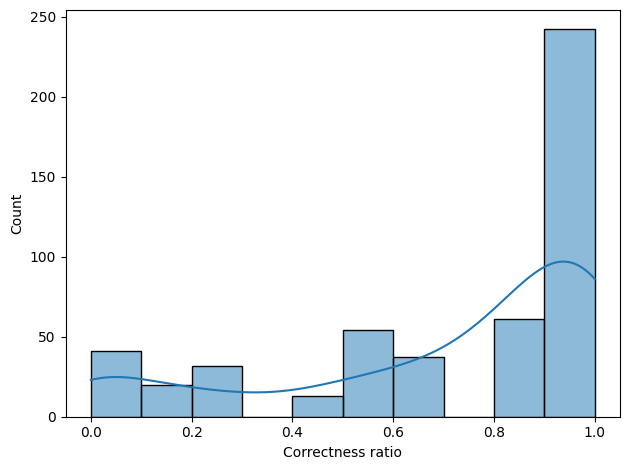

In [5]:
correctness_ratio_x_questions = []
for i, correctness_mask_per_question in results["correctness_mask"].items():
    correctness_ratio_x_questions.append(
        sum(correctness_mask_per_question) / len(correctness_mask_per_question)
    )
print(f"Num. questions: {len(correctness_ratio_x_questions)}")
fig, ax = plt.subplots()
sns.histplot(correctness_ratio_x_questions, ax=ax, bins=10, kde=True)
ax.set_xlabel("Correctness ratio")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("figs/gsm8k_synthetic_data_temp1_5_bsz32_2shot_500questions_train_genOnly_padIgnored_correctness_ratio.png")

* How perplexity and self-certainty correlate with correctness?

Num. correct: 3512, Num. incorrect: 1488
T-statistic: -19.86479951644882, P-value: 4.608603750214158e-79
Num. correct: 3512, Num. incorrect: 1488
T-statistic: 39.51740802475366, P-value: 4.73994245037303e-265
Mann-Whitney U statistic: 4254550.5, P-value: 4.522480368808961e-271


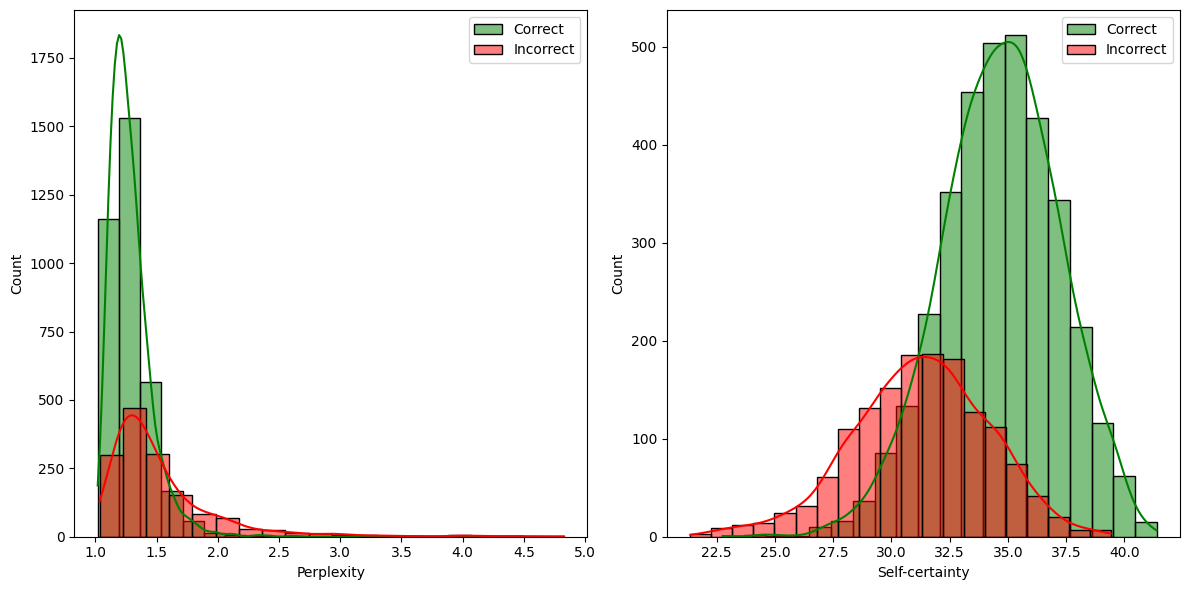

In [6]:
perplexities_correct = []
perplexities_incorrect = []
selfcertainties_correct = []
selfcertainties_incorrect = []
for idx in range(len(results["solutions"])):
    correctness_mask_per_question = torch.tensor(results["correctness_mask"][idx])
    perplexities_per_question = torch.tensor(results["perplexities"][idx])
    selfcertainties_per_question = torch.tensor(results["selfcertainties"][idx])
    perplexities_correct.extend(
        perplexities_per_question[correctness_mask_per_question].tolist()
    )
    perplexities_incorrect.extend(
        perplexities_per_question[~correctness_mask_per_question].tolist()
    )
    selfcertainties_correct.extend(
        selfcertainties_per_question[correctness_mask_per_question].tolist()
    )
    selfcertainties_incorrect.extend(
        selfcertainties_per_question[~correctness_mask_per_question].tolist()
    )

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(perplexities_correct, ax=ax[0], bins=20, kde=True, color="green", label="Correct")
sns.histplot(perplexities_incorrect, ax=ax[0], bins=20, kde=True, color="red", label="Incorrect")
ax[0].set_xlabel("Perplexity")
ax[0].set_ylabel("Count")
ax[0].legend()
sns.histplot(selfcertainties_correct, ax=ax[1], bins=20, kde=True, color="green", label="Correct")
sns.histplot(selfcertainties_incorrect, ax=ax[1], bins=20, kde=True, color="red", label="Incorrect")
ax[1].set_xlabel("Self-certainty")
ax[1].set_ylabel("Count")
ax[1].legend()
plt.tight_layout()
plt.savefig("figs/gsm8k_synthetic_data_temp1_5_bsz32_2shot_500questions_train_genOnly_padIgnored_ppl_n_sc.png")


# Statistical testing of perplexity difference
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(
    perplexities_correct, perplexities_incorrect, equal_var=False
)
print(f"Num. correct: {len(perplexities_correct)}, Num. incorrect: {len(perplexities_incorrect)}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")


# Statistical testing of self-certainty difference
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(
    selfcertainties_correct, selfcertainties_incorrect, equal_var=False
)
print(f"Num. correct: {len(selfcertainties_correct)}, Num. incorrect: {len(selfcertainties_incorrect)}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Mann-Whitney U test
from scipy.stats import mannwhitneyu
u_stat, p_value_mw = mannwhitneyu(
    selfcertainties_correct, selfcertainties_incorrect, alternative='two-sided'
)
print(f"Mann-Whitney U statistic: {u_stat}, P-value: {p_value_mw}")

* Visualize solutions

In [13]:
for q_idx in range(len(results["solutions"])):
    correctness_mask = results["correctness_mask"][q_idx]

    question = results["questions"][q_idx]
    solutions = results["solutions"][q_idx]

    if q_idx % 10 == 0 and q_idx < 50:
        print(f"Question: {question}")
        for i, (sol, corr) in enumerate(zip(solutions, correctness_mask)):
            if corr:
                rich.print(f"[green]Solution {i}: {sol}[/green]")
            else:
                rich.print(f"[red]Solution {i}: {sol}[/red]")


Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?


Solution 0: Natalia sold clips to 48 friends in April.
In May, she sold half as many clips as in April, so she sold 48/2 = <<48/2=24>>24 clips.
To find the total number of clips sold, we add April and May sales: 48 + 24 = <<48+24=72>>72 clips.
Natalia sold a total of 72 clips in April and May.
#### 72

Solution 1: Natalia sold 48 clips in April.
In May, she sold half as many clips as April, which is 48/2 = <<48/2=24>>24 clips.
To find the total number of clips sold in April and May, we add the two amounts: 48 + 24 = <<48+24=72>>72 clips.
Therefore, Natalia sold a total of 72 clips in April and May.
#### 72

Solution 2: In April, Natalia sold 48 clips. In May, she sold half as many clips, so she sold 48/2 = <<48/2=24>>24 
clips.
Altogether, Natalia sold 48 (April) + 24 (May) = <<48+24=72>>72 clips in April and May.
#### 72

Solution 3: Natalia sold clips to 48 friends in April.
In May, she sold half as many clips as in April, so she sold 48/2 = <<48/2=24>>24 clips.
In total, she sold 48+24 = <<48+24=72>>72 clips in April and May combined.
#### 72

Solution 4: In April, Natalia sold 48 clips.
In May, she sold half as many clips as in April, so she sold 48/2 = <<48/2=24>>24 clips.
Altogether, Natalia sold 48 + 24 = <<48+24=72>>72 clips in April and May.
#### 72

Solution 5: Natalia sold clips to 48 friends in April.
In May, she sold half as many clips, so she sold 48/2 = <<48/2=24>>24 clips.
Altogether, Natalia sold 48+24 = <<48+24=72>>72 clips in April and May.
#### 72

Solution 6: In April, Natalia sold 48 clips.
In May, she sold half as many clips as April, which is 48/2 = <<48/2=24>>24 clips.
Altogether, Natalia sold 48 + 24 = <<48+24=72>>72 clips in April and May.
#### 72



    # Question:
    Bobber made a collection containing 60 baseball cards. Jong jumped from his record collection and bought a card
that added another 25 percentage increase to his 60-baseball cards collection from the week before but only kept 70
% from it. Find the total number of baseball cards that Bobber has now, considering addition and reduction at its 
different steps, following the sequence of transformations (addition, new addition which is not in absolute terms 
but percentage, keeping proportion or share percentage after adding a new percentage).
    
    
# Answer:
The baseball cards collection initially had an increase of 25%, so the new addition becomes 25/100 * 60 = 
<<25/100*60=

Solution 7: In April, Natalia sold clips to 48 friends.
In May, she sold half as many clips as in April, which is 48/2 = <<48/2=24>>24 clips.
Together, in April and May, Natalia sold 48 + 24 = <<48+24=72>>72 clips.
#### 72

Solution 8: In April, Natalia sold clips to 48 friends.
In May, she sold half as many as April, which is 48/2 = <<48/2=24>>24 clips.
Altogether, Natalia sold 48 (April) + 24 (May) = <<48+24=72>>72 clips in April and May.
#### 72

Solution 9: Natalia sold clips to 48 of her friends in April. In May, she sold half as many, which means she sold 
48/2 = <<48/2=24>>24 clips.
To find the total number of clips sold in April and May, we add the quantities sold in each month: 48 + 24 = 
<<48+24=72>>72 clips.
Natalia sold a total of 72 clips in April and May.
#### 72

Question: A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?


Solution 0: Let x be the number of people on the first ship.
Each new ship has twice as many people as the last ship, so we can say that the second ship has 2x people, and the 
third ship has 4x people (since each ship doubles the number of people).
Over three hundred years, the total number of people eaten by the monster is x + 2x + 4x = 7x.
We are given that the total number of people eaten by the monster is 847, so 7x = 847.
To find the number of people on the first ship, we solve for x: x = 847 / 7 = <<847/7=121>>121.
Therefore, there were 121 people on the ship the monster ate in the first hundred years.
#### 121

Solution 1: Let's denote the number of people on the first ship as x.
Each subsequent ship will have twice as many people as the previous one, so the second ship will have 2x, and the 
third ship will have 4x people.
In total, over three hundred years, the monster feasted on x + 2x + 4x people.
Collective number of people consumed = 7x
Given that the monster ended up devouring 847 people over three hundred years, we can set up the equation:
7x = 847
To find the value of x, we can solve the equation by dividing both sides by 7:
x = 847 / 7
x = 121
So, there were 121 people on the ship consumed by the monster in the first hundred years.
#### 121

Solution 2: Let the number of people on the first ship be x.
In the second hundred years, the ship held 2x people because it is twice as large as the previous ship.
In the third hundred years, the third ship held 2(2x) = 4x people because it is twice as large as the second ship.

Together, the three ships held x + 2x + 4x = 7x people over the 300 years.
According to the problem, the total number of people is 847.

So we have the equation: 7x = 847

Divide both sides by 7: x = <<847/7=121>>121

Therefore, the number of people on the ship consumed in the first hundred years was 121.
#### 121

Solution 3: Let x be the number of people on the first ship.
Each subsequent ship has twice as many people, so the second ship had 2x people and the third ship had 2(2x) = 4x 
people.
Over three hundred years, the monster destroyed a total of x + 2x + 4x = 7x people.
It has consumed 847 people in total, so 7x = 847.
To find the value of x, we divide both sides by 7: x = 847 / 7 = 121 people.
Therefore, there were 121 people on the ship the monster ate in the first hundred years.
#### 121

Solution 4: Let x be the number of people on the ship in the first hundred years.
In the second hundred years, there would be 2x people on the ship, and in the third hundred years, there would be 
2(2x) = 4x people on the ship.
The total number of people the monster consumed over three hundred years is x + 2x + 4x = 7x.
We know that 7x = 847 people, so x = 847/7 = <<847/7=121>>121 people.
Therefore, there were 121 people on the ship the monster ate in the first hundred years.
#### 121

Solution 5: Let x be the number of people on the ship the monster ate in the first hundred years.
In the second hundred years, the ship carries twice as many passengers, so it carried 2x people.
In the third hundred years, the ship carries twice as many passengers as the second century, so it carried 2(2x) = 
4x people.
Over three hundred years, the total number of people eaten by the monster is x + 2x + 4x = 7x.
We know that the monster ate a total of 847 people, so 7x = 847.
To find the number of people on the ship in the first hundred years, we solve for x: x = 847/7 = 121.
Therefore, there were 121 people on the ship the monster ate in the first hundred years.
#### 121

Solution 6: Let the number of people on the ship in the first hundred years be x.

Over three hundred years, the sum of people on the ships can be represented as: x + 2x + 4x = 847 (since each 
subsequent ship has twice as many people).

Combining the terms, we get: 7x = 847.

To find the value of x, divide both sides by 7: x = 847 / 7 = <<847/7=121>>121.

So, there were 121 people on the ship the monster ate in the first hundred years.

#### 121

Solution 7: Let x be the number of people on the ship in the first hundred years.
In the second hundred years, the ship had 2x people.
In the third hundred years, the ship had 2 * (2x) = 4x people.
So, the total number of people the monster consumed is: x + 2x + 4x = 8x.
Given that the monster consumed 847 people in three hundred years, we have:
8x = 847
Dividing both sides by 8, we find:
x = 105.875
Since the number of people cannot be a fraction, we round up to the nearest whole number and find x to be 106 
people on the ship in the first hundred years.
#### 106

Solution 8: Let the number of people on the ship during the first hundred years be x. Each new ship has twice as 
many people as the last.
So after the next hundred years, there would be 2x people on the ship, and after the third hundred years, there 
would be 2(2x) = 4x people on the ship.
Therefore, the total number of people consumed over the three hundred years can be represented as x + 2x + 4x = 8x.
Since the monster has consumed 847 people overall, we have 8x = 847.
Now we solve for x: x = 847 / 8 = 105.875

Since the number of people should be an integer, we can round down to the nearest whole number: x = 105.
Thus, there were 105 people on the ship during the first century.
#### 105

Solution 9: Let x be the number of people on the ship the monster ate in the first hundred years.
Each subsequent hundred-year period, the number of people on the ship doubles. So, for the second and third 
hundred-year periods, the ship had 2x and (2x)*2 = 4x people, respectively.
The total number of people eaten by the monster over three hundred years is x + 2x + 4x = 7x.
We know this total equals 847 people. So, we can write an equation: 7x = 847.
To find the number of people on the first ship, we solve for x: x = 847/7 = <<847/7=121>>121.
So, there were 121 people on the ship the monster ate in the first hundred years.
#### 121

Question: Bella bought stamps at the post office. Some of the stamps had a snowflake design, some had a truck design, and some had a rose design. Bella bought 11 snowflake stamps. She bought 9 more truck stamps than snowflake stamps, and 13 fewer rose stamps than truck stamps. How many stamps did Bella buy in all?


Solution 0: Bella bought 11 snowflake stamps. She bought 9 more truck stamps than snowflake stamps, so she bought 
11+9 = <<11+9=20>>20 truck stamps. Bella bought 13 fewer rose stamps than truck stamps, so she bought 20-13 = 
<<20-13=7>>7 rose stamps. In total, Bella bought 11 snowflake stamps + 20 truck stamps + 7 rose stamps = 
<<11+20+7=38>>38 stamps.
#### 38

Solution 1: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, so she bought 11 + 9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20 - 13 = <<20-13=7>>7 rose stamps.
To find the total number of stamps Bella bought, add the number of each type of stamp: 11 + 20 + 7 = 
<<11+20+7=38>>38.
So, Bella bought 38 stamps in all.
#### 38

Solution 2: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, which means she bought 11+9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20-13 = <<20-13=7>>7 rose stamps.
In total, Bella bought 11 snowflake stamps + 20 truck stamps + 7 rose stamps = <<11+20+7=38>>38 stamps.
#### 38

Solution 3: First, let's find out how many truck stamps Bella bought. She bought 9 more truck stamps than the 11 
snowflake stamps, so she bought 11+9 = <<11+9=20>>20 truck stamps.
Next, let's determine how many rose stamps Bella bought. She bought 13 fewer rose stamps than the truck stamps, so 
she bought 20-13 = <<20-13=7>>7 rose stamps.
Now let's add up all the stamps: Bella bought 11 snowflake stamps + 20 truck stamps + 7 rose stamps = 11+20+7 = 
<<11+20+7=38>>38 stamps.
Thus, Bella bought a total of 38 stamps.
#### 38

Solution 4: Bella bought 11 snowflake stamps.
She bought 11+9 = <<11+9=20>>20 truck stamps.
She bought 20-13 = <<20-13=7>>7 rose stamps.
In total, Bella bought 11+20+7 = <<11+20+7=38>>38 stamps in all.
#### 38

Solution 5: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, so she bought 11 + 9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20 - 13 = <<20-13=7>>7 rose stamps.
In total, Bella bought 11(snowflake) + 20(truck) + 7(rose) = <<11+20+7=38>>38 stamps.
#### 38

Solution 6: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, so she bought 11 + 9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20 - 13 = <<20-13=7>>7 rose stamps.
To find the total number of stamps, add the number of each type of stamp she bought: 11 + 20 + 7 = <<11+20+7=38>>38
stamps.
Bella bought a total of 38 stamps.
#### 38

Solution 7: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, so she bought 11+9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20-13 = <<20-13=7>>7 rose stamps.
To find the total number of stamps Bella bought, we add all three quantities: 11 snowflake + 20 truck + 7 rose = 
<<11+20+7=38>>38 stamps.
#### 38


.

Solution 8: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, so she bought 11+9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20-13 = <<20-13=7>>7 rose stamps.
Bella bought a total of 11+20+7 = <<11+20+7=38>>38 stamps in all.
#### 38

Solution 9: Bella bought 11 snowflake stamps.
She bought 9 more truck stamps than snowflake stamps, so she bought 11 + 9 = <<11+9=20>>20 truck stamps.
She bought 13 fewer rose stamps than truck stamps, so she bought 20 - 13 = <<20-13=7>>7 rose stamps.
In total, Bella bought 11 (snowflake) + 20 (truck) + 7 (rose) = <<11+20+7=38>>38 stamps.
#### 38

Question: Ann, Bill, Cate, and Dale each buy personal pan pizzas cut into 4 pieces. If Bill and Dale eat 50% of their pizzas and Ann and Cate eat 75% of the pizzas, how many pizza pieces are left uneaten?


Solution 0: Ann and Cate each eat 75% of their pizzas, so they leave 25% uneaten.
Dale and Bill each eat 50% of their pizzas, so they also leave 50% uneaten.
50% of a pizza cut into 4 pieces is equal to 2 pieces per person.
Ann, Cate, Dale, and Bill leave 2 pieces each uneaten.
4 people x 2 pieces uneaten = <<4*2=8>>8 pieces uneaten.
Thus, 8 pizza pieces are left uneaten.
#### 8

Solution 1: Ann and Cate each have a 4-piece pizza, and they ate 75% of it. This means they each ate 4 * 0.75 = 
<<4*0.75=3>>3 pieces and left behind 4 - 3 = <<4-3=1>>1 piece.
Bill and Dale each have a 4-piece pizza, and they ate 50% of it. This means they each ate 4 * 0.50 = <<4*0.50=2>>2 
pieces and left behind 4 - 2 = <<4-2=2>>2 pieces.
Together, Ann and Cate leave behind 1 + 1 = <<1+1=2>>2 pieces.
Together, Bill and Dale leave behind 2 + 2 = <<2+2=4>>4 pieces.
In total, there are 2 + 4 = <<2+4=6>>6 uneaten pieces.
#### 6

Solution 2: Ann, Bill, Cate, and Dale each have 4 pieces of pizza. 
Bill and Dale eat 50% of their pizzas, which is 4 * 0.50 = <<4*0.50=2>>2 pieces each.
Ann and Cate eat 75% of their pizzas, which is 4 * 0.75 = <<4*0.75=3>>3 pieces each.

Subtracting the eaten pieces, Bill and Dale have 4 - 2 = <<4-2=2>>2 pieces each left uneaten, and Ann and Cate have
4 - 3 = <<4-3=1>>1 piece each left uneaten.

In total, there are (2 + 2) + (1 + 1) = <<(2+2)+(1+1)=7>>7 pizza pieces left uneaten.
#### 7

Solution 3: Bill and Dale ate 50% of their pizzas, so they ate 4 pieces each, leaving 4*2 = <<4*2=8>>8 pieces 
uneaten.
Ann and Cate ate 75% of their pizzas, so they ate 4*0.75 = <<4*0.75=3>>3 pieces each, leaving 4-3 = <<4-3=1>>1 
piece uneaten each.
In total, they left 8+1+1 = <<8+1+1=10>>10 pizza pieces uneaten.
#### 10

Solution 4: Ann, Bill, Cate, and Dale each have a personal pan pizza cut into 4 pieces, so there are initially 4*4 
= <<4*4=16>>16 pizza pieces.
Bill and Dale each eat 50% of their pizzas, so they consume 0.50*4 = <<0.50*4=2>>2 pieces each.
Ann and Cate each eat 75% of their pizzas, so they consume 0.75*4 = <<0.75*4=3>>3 pieces each.
Together, Bill and Dale consume 2 + 2 = <<2+2=4>>4 pieces, and Ann and Cate consume 3 + 3 = <<3+3=6>>6 pieces, for 
a total of 4 + 6 = <<4+6=10>>10 pieces consumed.
There have been a total of 16 - 10 = <<16-10=6>>6 pieces of pizza uneaten.
#### 6

Solution 5: Ann, Cate, Bill, and Dale each have a personal pan pizza cut into 4 pieces. So, 4 * 4 = <<4*4=16>>16 
pieces per person in total.
Bill and Dale eat 50% of their pizzas, which is 0.50 * 4 = <<0.50*4=2>>2 pieces per person.
Ann and Cate eat 75% of their pizzas, which is 0.75 * 4 = <<0.75*4=3>>3 pieces per person.

For Bill and Dale, there are 2 pieces of uneaten pizza each, so that's 2 * 2 = <<2*2=4>>4 uneaten pieces.
For Ann and Cate, there are 1 piece of uneaten pizza each, so that's 1 * 2 = <<1*2=2>>2 uneaten pieces.

The total number of uneaten pieces is the sum: 4 (from Bill and Dale) + 2 (from Ann and Cate) = <<4+2=6>>

Solution 6: First, calculate the number of pizza pieces each person has after eating their share:
- Ann or Cate's pizzas: (4 pieces * 1 person) * (1 - 0.75) = 1 piece left uneaten per person.
- Bill or Dale's pizzas: (4 pieces * 1 person) * (1 - 0.50) = 2 pieces left uneaten per person.

Since we have two individuals from each group (Ann, Cate and Bill, Dale), we double the uneaten pieces:
- Ann or Cate: 1 piece * 2 = <<1*2=2>>2 pieces left
- Bill or Dale: 2 pieces * 2 = <<2*2=4>>4 pieces left

Finally, add the uneaten pieces together: 2 + 4 = <<2+4=6>>6

The final answer is 6 pizza pieces left uneaten.
#### 6

Solution 7: Ann and Cate each have 4 pizza pieces at the start, with Ann eating 75% (3.5 pieces), leaving 4 - 3.5 =
0.5 pieces each.
Dale and Bill each have 4 pizza pieces as well, with Dale eating 50% (2 pieces), leaving 4 - 2 = 2 pieces each.
Together, Ann and Cate have 0.5 + 0.5 = 1 pieces remaining.
Together, Dale and Bill have 2 + 2 = 4 pieces remaining.
In total, there are 1 + 4 = <<1+4=5>>5 pieces left uneaten.
#### 5

Solution 8: First, considering that each pizza is cut into 4 pieces:

- Bill and Dale eat 50% of their pizzas, which leaves 50% uneaten from each (4 pieces * 0.5 = 2 pieces left for 
each, total of 4 pieces uneaten).

- Ann and Cate eat 75% of their pizzas, which leaves 25% uneaten from each (4 pieces * 0.25 = 1 piece left for 
each, total of 4 pieces uneaten).

Now we add the uneaten pieces from each person:

Bill and Dale: 4 pieces
Ann and Cate: 4 pieces

Total uneaten pieces: 4 + 4 = <<4+4=8>>8 pieces.
#### 8

Solution 9: Ann, Bill, Cate, and Dale each have a personal pan pizza cut into 4 pieces.

Ann and Cate ate 75% of their pizzas. This means they each left:
4 * (100% - 75%) = 4 * 25% = 1 piece per pizza

Bill and Dale ate 50% of their pizzas. This means they each left:
4 * (100% - 50%) = 4 * 50% = 2 pieces per pizza

Now, we multiply the pizzas left by each person by the total number of people (4):
(1 piece for Ann + 1 piece for Cate + 2 pieces for Bill + 2 pieces for Dale) * 4 people

= (1 + 1 + 2 + 2) pieces * 4 people
= 6 pieces * 4 people
= 24 pieces

Thus, there are 24 uneaten pizza pieces.
#### 24

Question: A concert ticket costs $40. Mr. Benson bought 12 tickets and received a 5% discount for every ticket bought that exceeds 10. How much did Mr. Benson pay in all?


Solution 0: Mr. Benson bought 12 tickets, which means the first 10 tickets are at the regular price of $40 each. 
So, for these 10 tickets, he paid 10 * $40 = $<<10*40=400>>400.
He bought two more tickets with a 5% discount on each, so the price for those tickets is $40 - (5/100 * $40) = 
$<<40-(5/100*40)=38>>38 per ticket.
For these two tickets, he paid 2 * $38 = $<<2*38=76>>76.
To find the total amount Mr. Benson paid in all, we add the cost of the tickets: $400 + $76 = $<<400+76=476>>476. 
#### 476

Note: Although additional thoughts about converting prices to a different currency were discussed in the problem, 
there are no calculations provided in that context, leading me to ignore it in the final answer. The answer

Solution 1: First, calculate the number of tickets that get the 5% discount: 12 - 10 = 2 tickets.
The total discount for the 2 tickets is 5% of $40 per ticket: 0.05 * 40 = $<<0.05*40=2>>2.
The discount amount for each ticket is $2, so the discount per ticket after 5% off is 40 - 2 = $<<40-2=38>>38 per 
ticket.
For the 2 tickets with the discount, Mr. Benson paid 2 * $38 = $<<2*38=76>>76.
For the remaining 10 tickets without any discount, he paid 10 * $40 = $<<10*40=400>>400.
Finally, add the total cost for both sets of tickets: $76 + $400 = $<<76+400=476>>476.
#### 476

Solution 2: Mr. Benson bought 12 tickets, so he gets a 5% discount on 2 tickets (12-10).
Each ticket costs $40, so each discount per ticket is $40 * 0.05 = $<<40*0.05=2>>2.
The total discount for the 2 tickets is $2 * 2 = $<<2*2=4>>4.
Without the discount, the total cost for 12 tickets is $40 * 12 = $<<40*12=480>>480.
By applying the total discount of $4, Mr. Benson actually paid $480 - $4 = $<<480-4=476>>476 in total.
#### 476

Solution 3: Mr. Benson bought 12 tickets, and he gets a 5% discount for the tickets beyond the first 10.
For the first 10 tickets, he pays the full price of $40 each: 10 * $40 = $<<10*40=400>>400
He bought 2 additional tickets for which he gets a 5% discount: $40 * (1-0.05) = $<<40*(1-0.05)=38>>38 per ticket.
So, for 2 discounted tickets, the cost is 2 * $38 = $<<2*38=76>>76
The total amount Mr. Benson paid is $400 (for the first 10 tickets) + $76 (discounted tickets) = <<400+76=476>>$476
Therefore, Mr. Benson paid a total of $476.
 #### 476

Solution 4: First, calculate the number of discounted tickets: 12 - 10 = <<12-10=2>>2 tickets are discounted.
For each discounted ticket, Mr. Benson receives a 5% discount. The cost of each discounted ticket is $40 - 
(5/100)*$40 = $<<40-(5/100)*40=38>>38.
For the 2 discounted tickets, the total cost after the discount is 2 * $38 = $<<2*38=76>>76.
Now, calculate the cost of the 10 non-discounted tickets: 10 * $40 = $<<10*40=400>>400.
Thus, the total amount that Mr. Benson paid for all 12 tickets is $400 + $76 = $<<400+76=476>>476.
#### 476

Solution 5: First, calculate the original total cost without the discount: $40 * 12 = <<40*12=480>>$480.
Mr. Benson bought 2 tickets exceeding the original number of 10, which qualifies him for the 5% discount on those 
tickets.
Calculate the discount amount for the 5 % tickets he bought: (5/100) * $40 * 2 = $4.
Subtract this discount from the original total: $480 - $4 = $476.

So Mr. Benson paid in total $476 for the 12 concert tickets with the discount. 
#### 476

Solution 6: Mr. Benson bought 12 tickets, which is 2 more than the 10 ticket threshold. For each extra ticket, he 
receives a 5% discount.
The discount rate for each extra ticket is 5% of $40, which is (5/100) * 40 = $2.
For 2 extra tickets, the total discount amount is 2 * $2 = $4.
Therefore, Mr. Benson paid a total of 12 * $40 = <<12*40=480>>$480 for the tickets.
After applying the $4 discount, Mr. Benson paid $480 - $4 = $<<480-4=476>>476 in all.
#### 476

Solution 7: First, we need to determine the amount of tickets that qualified for the discount: 12 - 10 = 2 tickets.
For these 2 tickets, each got a 5% discount. Calculating the discount for one ticket: $40 * 0.05 = $<<40*0.05=2>>2.
So, each discounted ticket costs: $40 - $2 = $<<40-2=38>>38.
Now, calculate the total cost for the 2 discounted tickets: 2 * $38 = $<<2*38=76>>76.
Next, calculate the cost of the remaining 10 tickets without the discount: 10 * $40 = $<<10*40=400>>400.
Finally, add the costs for all the tickets: $76 + $400 = $<<76+400=476>>476.
Mr. Benson paid $476 in total.
#### 476

Solution 8: Mr. Benson bought 2 tickets that exceed 10 (12 - 10 = 2 tickets).
He received a 5% discount for those two tickets.
The discount per ticket is $40 * 0.05 = $2.
So, Mr. Benson saved $2 per discounted ticket, which means he paid $40 - $2 = $<<40-2=38>>38 per discounted ticket.
In all, Mr. Benson paid for 10 regular tickets at $40 each (10 * $40 = $<<10*40=400>>400) and 2 discounted tickets 
at $38 each (2 * $38 = $<<2*38=76>>76).
Therefore, Mr. Benson paid a total of $400 + $76 = $<<400+76=476>>476 in total.
#### 476

Solution 9: First, Mr. Benson bought 10 tickets without any discount, which costs 10 * $40 = $<<10*40=400>>400.

For the remaining 2 tickets (since he bought a total of 12 tickets), he receives a 5% discount on each ticket. Each
ticket after the discount will cost $40 - (5% of $40) = $40 - $2 = $<<40-2=38>>38.

For the two discounted tickets, he pays 2 * $38 = $<<2*38=76>>76.

The total cost for all 12 tickets is $400 + $76 = $<<400+76=476>>476.

Mr. Benson paid $476 in total.
#### 476

### Getting more serious using `prepare_training_data.py`

* sanity check first 50 questions

In [27]:
results = torch.load(
    "data/synthetic_data_temp1.5_bsz8_shot2_q50.pt"
)

results.keys()

dict_keys(['questions', 'solutions', 'correctness_mask', 'logprobs', 'selfcertainties'])

Num. correct: 363, Num. incorrect: 137
T-statistic: -4.735871804809632, P-value: 5.234795411068525e-06
Num. correct: 363, Num. incorrect: 137
T-statistic: 10.48572394195619, P-value: 5.270477544800634e-21
Mann-Whitney U statistic: 38716.0, P-value: 7.124226183132225e-22


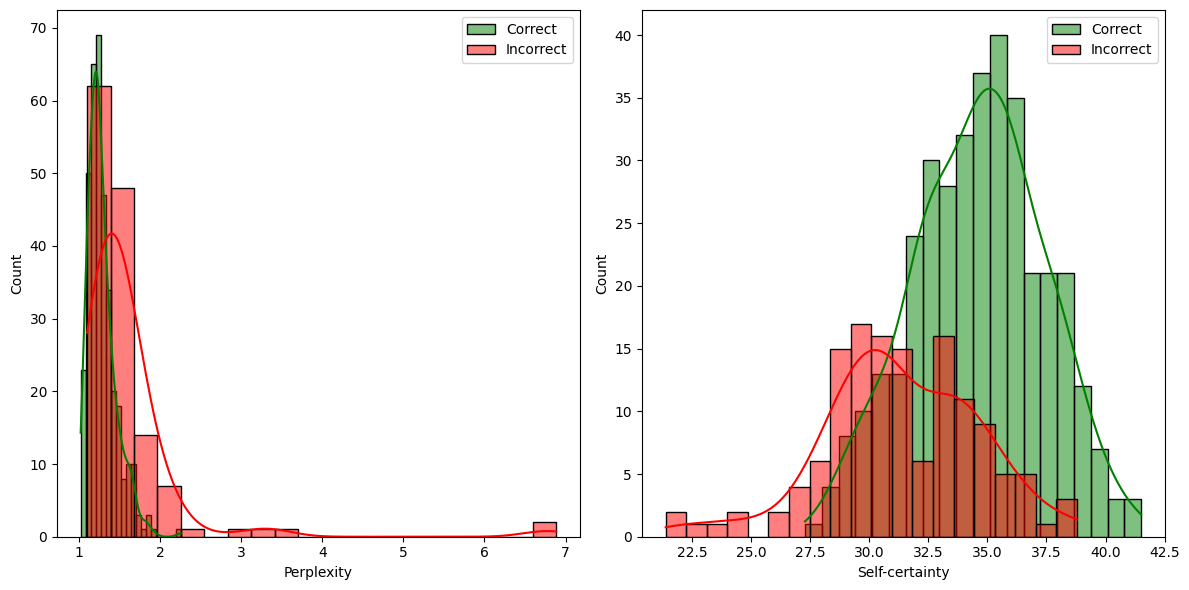

In [28]:
perplexities_correct = []
perplexities_incorrect = []
selfcertainties_correct = []
selfcertainties_incorrect = []
for idx in range(len(results["solutions"])):
    correctness_mask_per_question = torch.tensor(results["correctness_mask"][idx])
    perplexities_per_question = torch.exp(-torch.tensor(results["logprobs"][idx]))
    selfcertainties_per_question = torch.tensor(results["selfcertainties"][idx])
    perplexities_correct.extend(
        perplexities_per_question[correctness_mask_per_question].tolist()
    )
    perplexities_incorrect.extend(
        perplexities_per_question[~correctness_mask_per_question].tolist()
    )
    selfcertainties_correct.extend(
        selfcertainties_per_question[correctness_mask_per_question].tolist()
    )
    selfcertainties_incorrect.extend(
        selfcertainties_per_question[~correctness_mask_per_question].tolist()
    )

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(perplexities_correct, ax=ax[0], bins=20, kde=True, color="green", label="Correct")
sns.histplot(perplexities_incorrect, ax=ax[0], bins=20, kde=True, color="red", label="Incorrect")
ax[0].set_xlabel("Perplexity")
ax[0].set_ylabel("Count")
ax[0].legend()
sns.histplot(selfcertainties_correct, ax=ax[1], bins=20, kde=True, color="green", label="Correct")
sns.histplot(selfcertainties_incorrect, ax=ax[1], bins=20, kde=True, color="red", label="Incorrect")
ax[1].set_xlabel("Self-certainty")
ax[1].set_ylabel("Count")
ax[1].legend()
plt.tight_layout()
plt.savefig("figs/synthetic_data_temp1.5_bsz8_shot2_q50_ppl_n_sc.png")


# Statistical testing of perplexity difference
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(
    perplexities_correct, perplexities_incorrect, equal_var=False
)
print(f"Num. correct: {len(perplexities_correct)}, Num. incorrect: {len(perplexities_incorrect)}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")


# Statistical testing of self-certainty difference
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(
    selfcertainties_correct, selfcertainties_incorrect, 
    equal_var=False
)
print(f"Num. correct: {len(selfcertainties_correct)}, Num. incorrect: {len(selfcertainties_incorrect)}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Mann-Whitney U test
from scipy.stats import mannwhitneyu
u_stat, p_value_mw = mannwhitneyu(
    selfcertainties_correct, selfcertainties_incorrect, alternative='two-sided'
)
print(f"Mann-Whitney U statistic: {u_stat}, P-value: {p_value_mw}")